In [1]:
%matplotlib inline

import os, math, time, sys, shutil
import numpy as np
from pathlib import Path

from tifffile import imread, imwrite
# from imageio import mimwrite
import matplotlib.pyplot as plt

import cma
# import cv2 as cv

# import json

from gvxrPython3 import gvxr
#from gvxrPython3 import gvxr2json
from gvxrPython3 import json2gvxr
from gvxrPython3.utils import visualise, loadSpectrumSpekpy, loadSpectrumXpecgen, has_spekpy, has_xpecgen
# from untitled import visualise, loadSpectrumSpekpy, loadSpectrumXpecgen, has_spekpy, has_xpecgen


import utils
from utils import *

# import astra

spekpy is not install, you won't be able to load a beam spectrum using spekpy
xpecgen is not install, you won't be able to load a beam spectrum using xpecgen
SimpleGVXR 2.0.7 (2023-11-06T20:30:06) [Compiler: Microsoft Visual Studio] on Windows
gVirtualXRay core library (gvxr) 2.0.7 (2023-11-06T20:30:04) [Compiler: Microsoft Visual Studio] on Windows


In [2]:
registration_dir = os.path.join(base_dir, "registration")

if not os.path.exists(registration_dir):
    os.mkdir(registration_dir)

In [3]:
experimental_img_dir = os.path.join(base_dir, "Tomography_01_all_proj")
experimental_img_paths = sorted(
    [
        os.path.join(experimental_img_dir, fname)
        for fname in os.listdir(experimental_img_dir)
        if fname.endswith(".tif")
    ]
)

In [4]:
# data = np.loadtxt(base_dir + "/geom.csv", 
#     delimiter=';',
#     skiprows=2,
#     usecols=(1,2,3,4,5,6,7,8,9,10,11,12))

# new_columns = [
#     "source - x",
#     "source - y",
#     "source - z",
#     "Imager Center - x",
#     "Imager Center - y",
#     "Imager Center - z",
#     "Imager Top - x",
#     "Imager Top - y",
#     "Imager Top - z",
#     "Imager Right - x",
#     "Imager Right - y",
#     "Imager Right - z"
# ]

XraykV=120

SrcToObject=77.9902725219727
SrcToDetector=990.8258


odd = SrcToDetector - SrcToObject
sod = SrcToObject

DetectorPixelsX=1008
DetectorPixelsY=1008
DetectorPixelSizeX=0.127
DetectorPixelSizeY=0.127

#AngularStep=0.227416298168035
Projections=663
WhiteLevel=60000

N_slices = Projections
angles = np.linspace(0, 360, N_slices, False)

# We checked that AngularStep is equal to (angles[1] - angles[0])

In [5]:
# rx_shape = rx_dimy, rx_dimx

# source_position = data[:,:3]
# detector_position = data[:,3:6]
# detector_v = (data[:,6:9] - detector_position) / rx_shape[1] * 2
# detector_u = (data[:,9:] - detector_position) / rx_shape[0] * 2

# Y = 0.5 * source_position[:,1].mean() + 0.5 * detector_position[:,1].mean()
# source_position[:,1] -= Y
# detector_position[:,1] -= Y

# # Modify the coordinate system
# # X -> Y
# # Y -> Z
# # Z -> X
# source_position = np.roll(source_position, 1, axis=1)
# detector_position = np.roll(detector_position, 1, axis=1)
# detector_v = np.roll(detector_v, 1, axis=1)
# detector_u = np.roll(detector_u, 1, axis=1)

# sod = np.sum(source_position**2, axis=1)**.5
# sdd = np.sum((source_position-detector_position)**2, axis=1)**.5
# odd = np.sum(detector_position**2, axis=1)**.5

# print("SOD:", sod.mean(), "+/-", sod.std())
# print("SDD:", odd.mean(), "+/-", sdd.std())
# print("ODD:", odd.mean(), "+/-", odd.std())

In [6]:
# Create an OpenGL context
print("Create an OpenGL context")
gvxr.createOpenGLContext();

Create an OpenGL context


In [7]:
if has_spekpy:
    loadSpectrumSpekpy(XraykV, filters=None, th_in_deg=12)
elif has_xpecgen:
    loadSpectrumXpecgen(XraykV, filters=None, th_in_deg=12)

In [8]:
mesh_dir = os.path.join(base_dir, "meshes")


gvxr.removePolygonMeshesFromSceneGraph()

for label in ["steel-smoothed"]:
    mesh_fname = os.path.join(mesh_dir, label + ".stl")
    gvxr.loadMeshFile(label, mesh_fname, "mm")

gvxr.setMixture("steel-smoothed",
                utils.elements,
                utils.default_weights) # Aluminium 2024


gvxr.setDensity("steel-smoothed", default_density, "g/cm3")
gvxr.setColour("steel-smoothed", 132/255, 135/255, 137/255, 1.0)


bbox_in_mm = gvxr.getNodeAndChildrenBoundingBox("steel-smoothed", "mm")


for label in ["steel-smoothed"]:
    # gvxr.scaleNode(label, -1, 1, 1)

    gvxr.translateNode(label,
                       -bbox_in_mm[0] - (bbox_in_mm[3] - bbox_in_mm[0]) / 2.0,
                       -bbox_in_mm[1] - (bbox_in_mm[4] - bbox_in_mm[1]) / 2.0,
                       -bbox_in_mm[2] - (bbox_in_mm[5] - bbox_in_mm[2]) / 2.0,
                       "mm"
                      )
    
    # gvxr.invertNormalVectors("label")

bbox_in_mm = gvxr.getNodeAndChildrenBoundingBox("steel-smoothed", "mm")

print("Bounding box:", bbox_in_mm, "mm")
print("Dimensions:", bbox_in_mm[3] - bbox_in_mm[0], bbox_in_mm[4] - bbox_in_mm[1], bbox_in_mm[5] - bbox_in_mm[2], "mm")

Bounding box: (-2.602853298187256, -2.5947957038879395, -4.908654689788818, 2.602853298187256, 2.5947957038879395, 4.908654689788818) mm
Dimensions: 5.205706596374512 5.189591407775879 9.817309379577637 mm


In [9]:
# Set its spectrum, here a monochromatic beam
# 15000 photons of 98 keV per ray
gvxr.setMonoChromatic(98, "keV", 15000);
    
gvxr.usePointSource();

In [10]:
downscale = 8
gvxr.setDetectorNumberOfPixels(round(DetectorPixelsX / downscale), round(DetectorPixelsY / downscale));
gvxr.setDetectorPixelSize(DetectorPixelSizeX * downscale, DetectorPixelSizeY * downscale, "mm");

In [11]:
# src_pos = source_position[0]
# det_pos = detector_position[0]
# u = detector_u[0]
# u /= np.sum(u**2)**.5
# v = detector_v[0]
# v /= np.sum(v**2)**.5

# print("Source position:", src_pos, "mm")
# print("Detector position:", det_pos, "mm")
# print("Detector U:", u)
# print("Detector V:", v)

# gvxr.setDetectorPosition(det_pos[0], det_pos[1], det_pos[2], "mm");
# gvxr.setDetectorUpVector(v[0], v[1], v[2]);
# gvxr.setDetectorRightVector(u[0], u[1], u[2]);

# gvxr.setSourcePosition(src_pos[0], src_pos[1], src_pos[2], "mm");


gvxr.autoAlignDetector(True)
gvxr.setDetectorPosition(0, -odd, 0, "mm");
gvxr.setDetectorUpVector(0, 0, -1);
# gvxr.setDetectorRightVector(u[0], u[1], u[2]);

gvxr.setSourcePosition(0, sod, 0, "mm");


# Compute an X-ray image
# We convert the array in a Numpy structure and store the data using single-precision floating-point numbers.
x_ray_image = np.array(gvxr.computeXRayImage()).astype(np.single)

# Update the visualisation window
gvxr.displayScene()
gvxr.setZoom(1220)
gvxr.setSceneRotationMatrix((0.7875528931617737, -0.019898230209946632, 0.6159240007400513, 0.0, 0.6153900027275085, 0.07806847244501114, -0.7843458652496338, 0.0, -0.03247729688882828, 0.9967493414878845, 0.07372806966304779, 0.0, 0.0, 0.0, 0.0, 1.0))
gvxr.displayScene()
# gvxr.renderLoop()

In [12]:
downscale = 8
utils.ref_image, utils.selected_angles, utils.indices = getReference(experimental_img_paths, 
                                                                     angles, 
                                                                     3, 
                                                                     WhiteLevel,
                                                                     downscale);

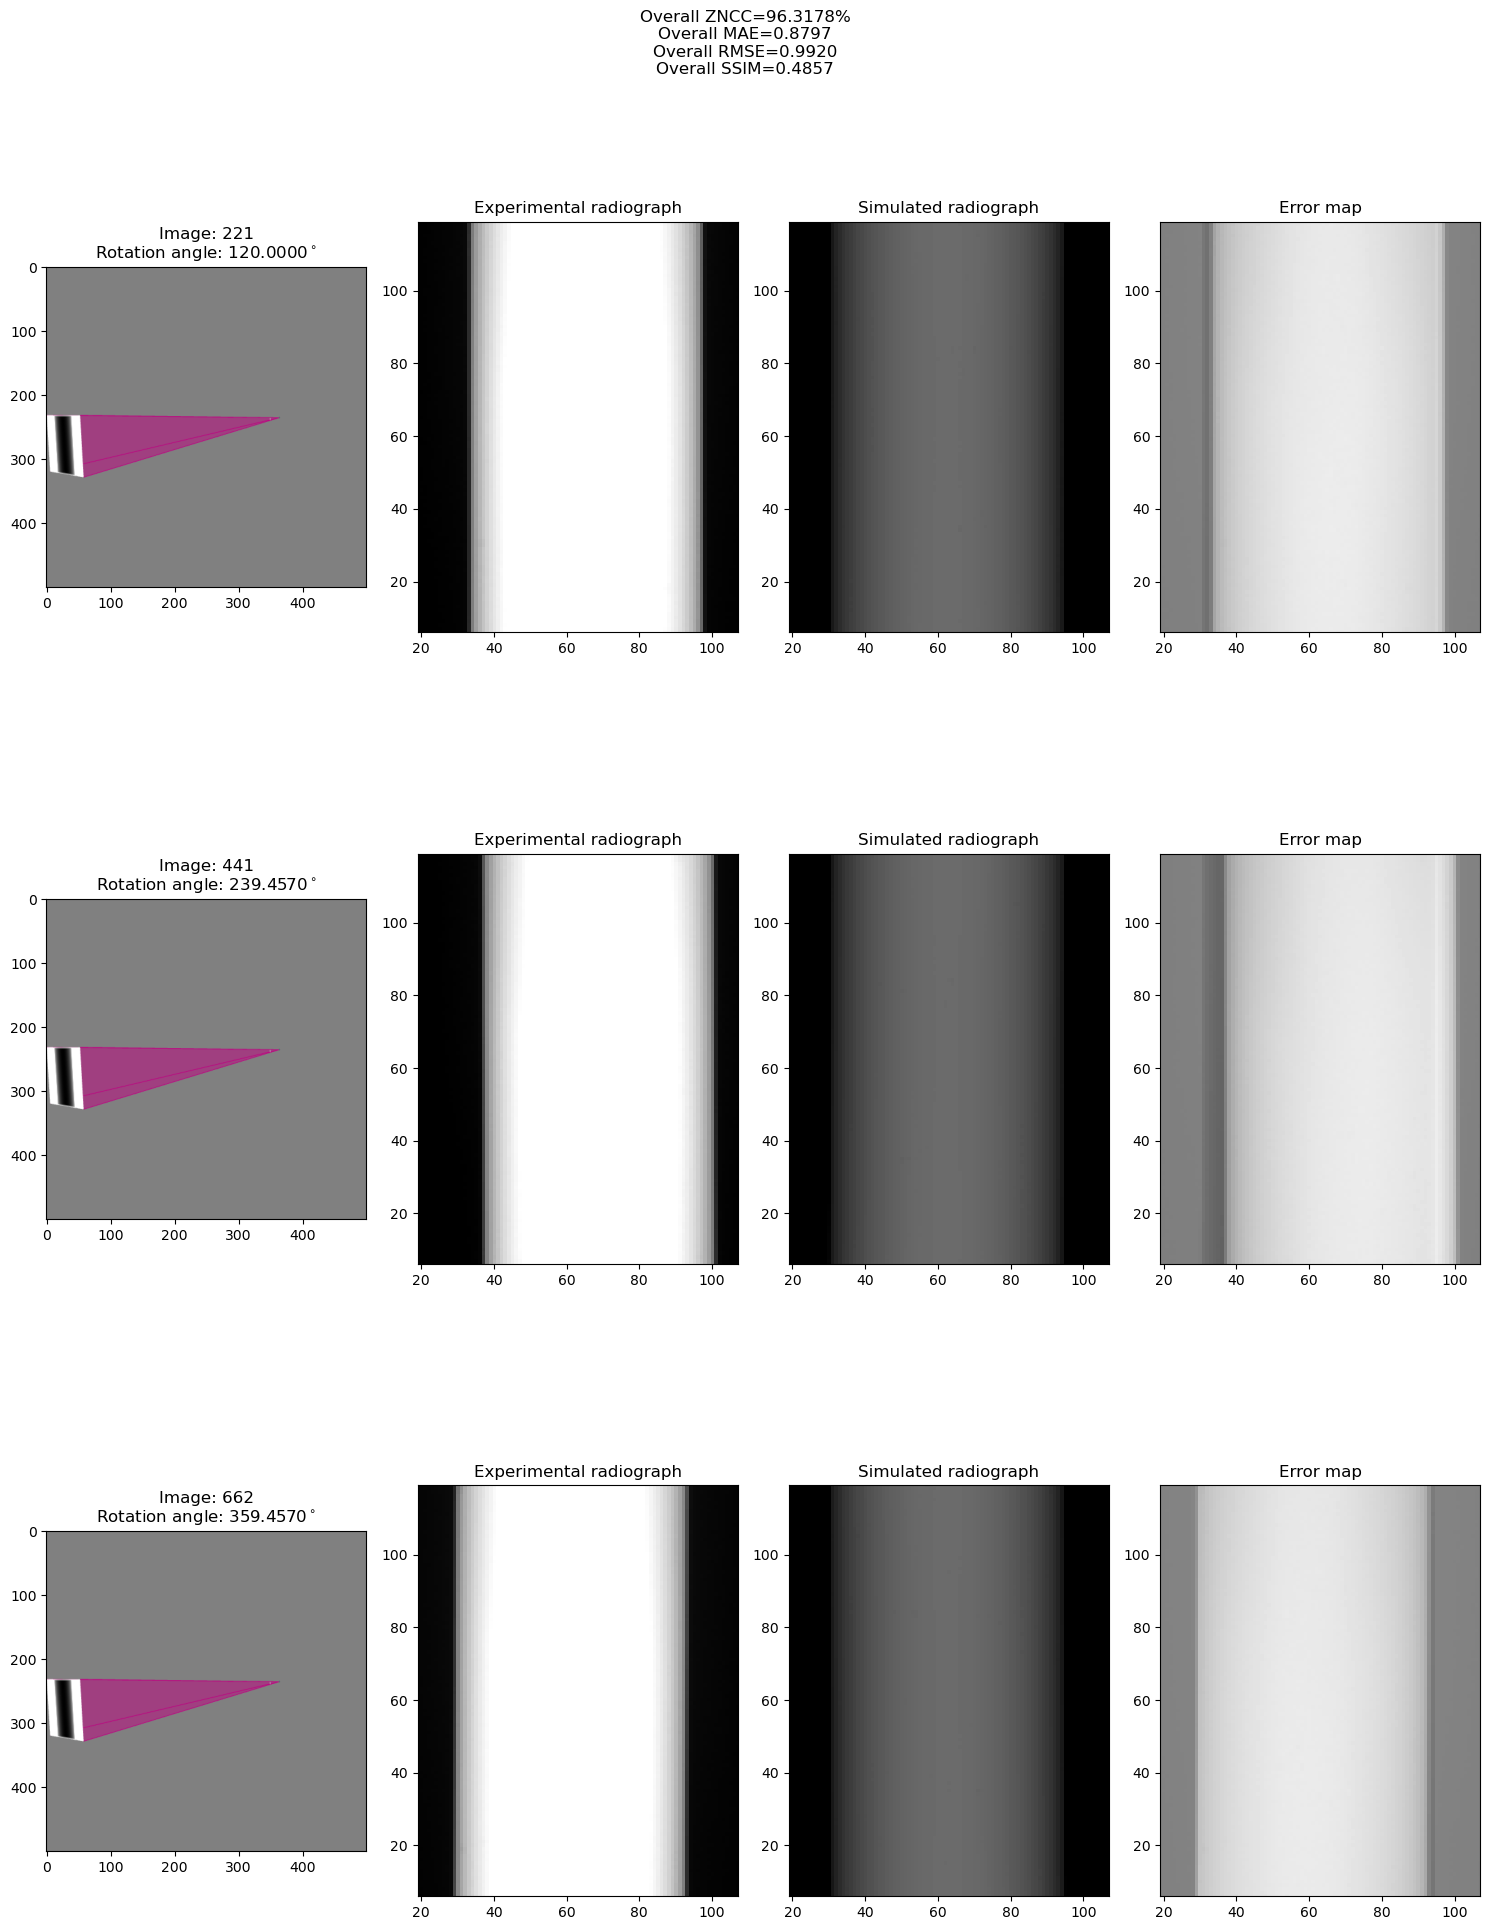

In [13]:
utils.figsize = (15, 21)
displayResult(x_default, figsize=utils.figsize, fname=None, crop=True)

In [14]:
opts = cma.CMAOptions()
opts.set('tolfun', 1e-5);
opts['tolx'] = 1e-5;
opts['bounds'] = [
    6*[-6],
    6*[6]
]

x_fname       = os.path.join(registration_dir, "x_best1.dat")
fitness_fname = os.path.join(registration_dir, "fitness_set1.npz")
utils.plot_directory = os.path.join(registration_dir, "plot1")

if not os.path.exists(x_fname) or not os.path.exists(fitness_fname):
    
    if os.path.isdir(utils.plot_directory):
        shutil.rmtree(utils.plot_directory)

    if not os.path.exists(utils.plot_directory):
        os.mkdir(utils.plot_directory)    

    utils.best_fitness = sys.float_info.max
    utils.fitness_set = []
    utils.counter = 1

    start_time = time.time();
    es = cma.CMAEvolutionStrategy(np.hstack((6*[0])), 2 / 10, opts);
    es.optimize(fitnessZNCC);
    elapsed_time = time.time() - start_time

    x_best1 = es.result.xbest
    np.savetxt(x_fname, es.result.xbest)

    utils.fitness_set = np.array(utils.fitness_set)
    np.savez(fitness_fname, utils.fitness_set)

    
else:
    x_best1 = np.loadtxt(x_fname)
    data = np.load(fitness_fname)
    lst = data.files
    utils.fitness_set = data[lst[0]]

utils.x_current = x_best1

(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=1034450, Tue May 28 06:23:03 2024)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      9 1.027247026923346e+00 1.0e+00 1.83e-01  2e-01  2e-01 0:02.5
    2     18 1.031232341971569e+00 1.2e+00 1.66e-01  2e-01  2e-01 0:03.4
    3     27 1.031650742935859e+00 1.2e+00 1.58e-01  1e-01  2e-01 0:04.2
    7     63 1.028621680607297e+00 1.6e+00 1.00e-01  8e-02  1e-01 0:08.0
    8     72 1.022719762683955e+00 1.6e+00 8.66e-02  6e-02  8e-02 0:14.5
   11     99 1.020874449066505e+00 2.0e+00 6.88e-02  5e-02  6e-02 0:25.7
   16    144 1.020456374326011e+00 2.3e+00 4.75e-02  3e-02  4e-02 0:33.5
   20    180 1.020056385267772e+00 2.4e+00 3.36e-02  2e-02  3e-02 0:43.2
   22    198 1.019325811254407e+00 2.7e+00 3.76e-02  2e-02  4e-02 0:53.3
   27    243 1.018773837596056e+00 3.9e+00 3.87e-02  2e-02  4e-02 1:05.5
   31    279 1.017142290235770e+00 4.9e+00 5.46e-02  2e-02  6e-02 1:15.7
   35    315 1.015133867824310e+00

In [15]:
print(utils.x_current)

[-0.11416301  3.11114541  0.00485101 -0.19596115 -2.96250962 -1.30033494]


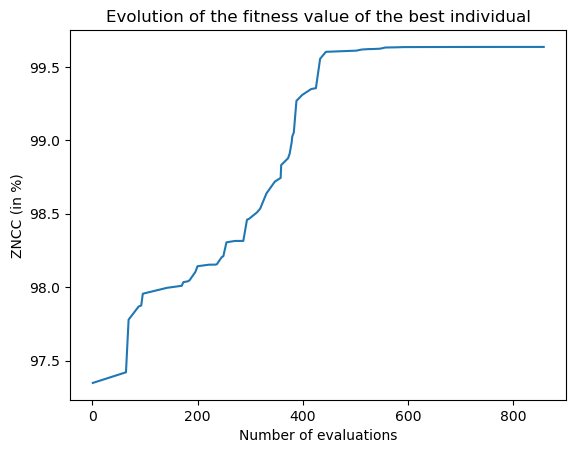

In [16]:
plt.figure()
plt.title("Evolution of the fitness value of the best individual")
plt.ylabel("ZNCC (in %)")
plt.xlabel("Number of evaluations")
plt.plot(utils.fitness_set[:, 0], 100.0 / utils.fitness_set[:, 1])
plt.show()

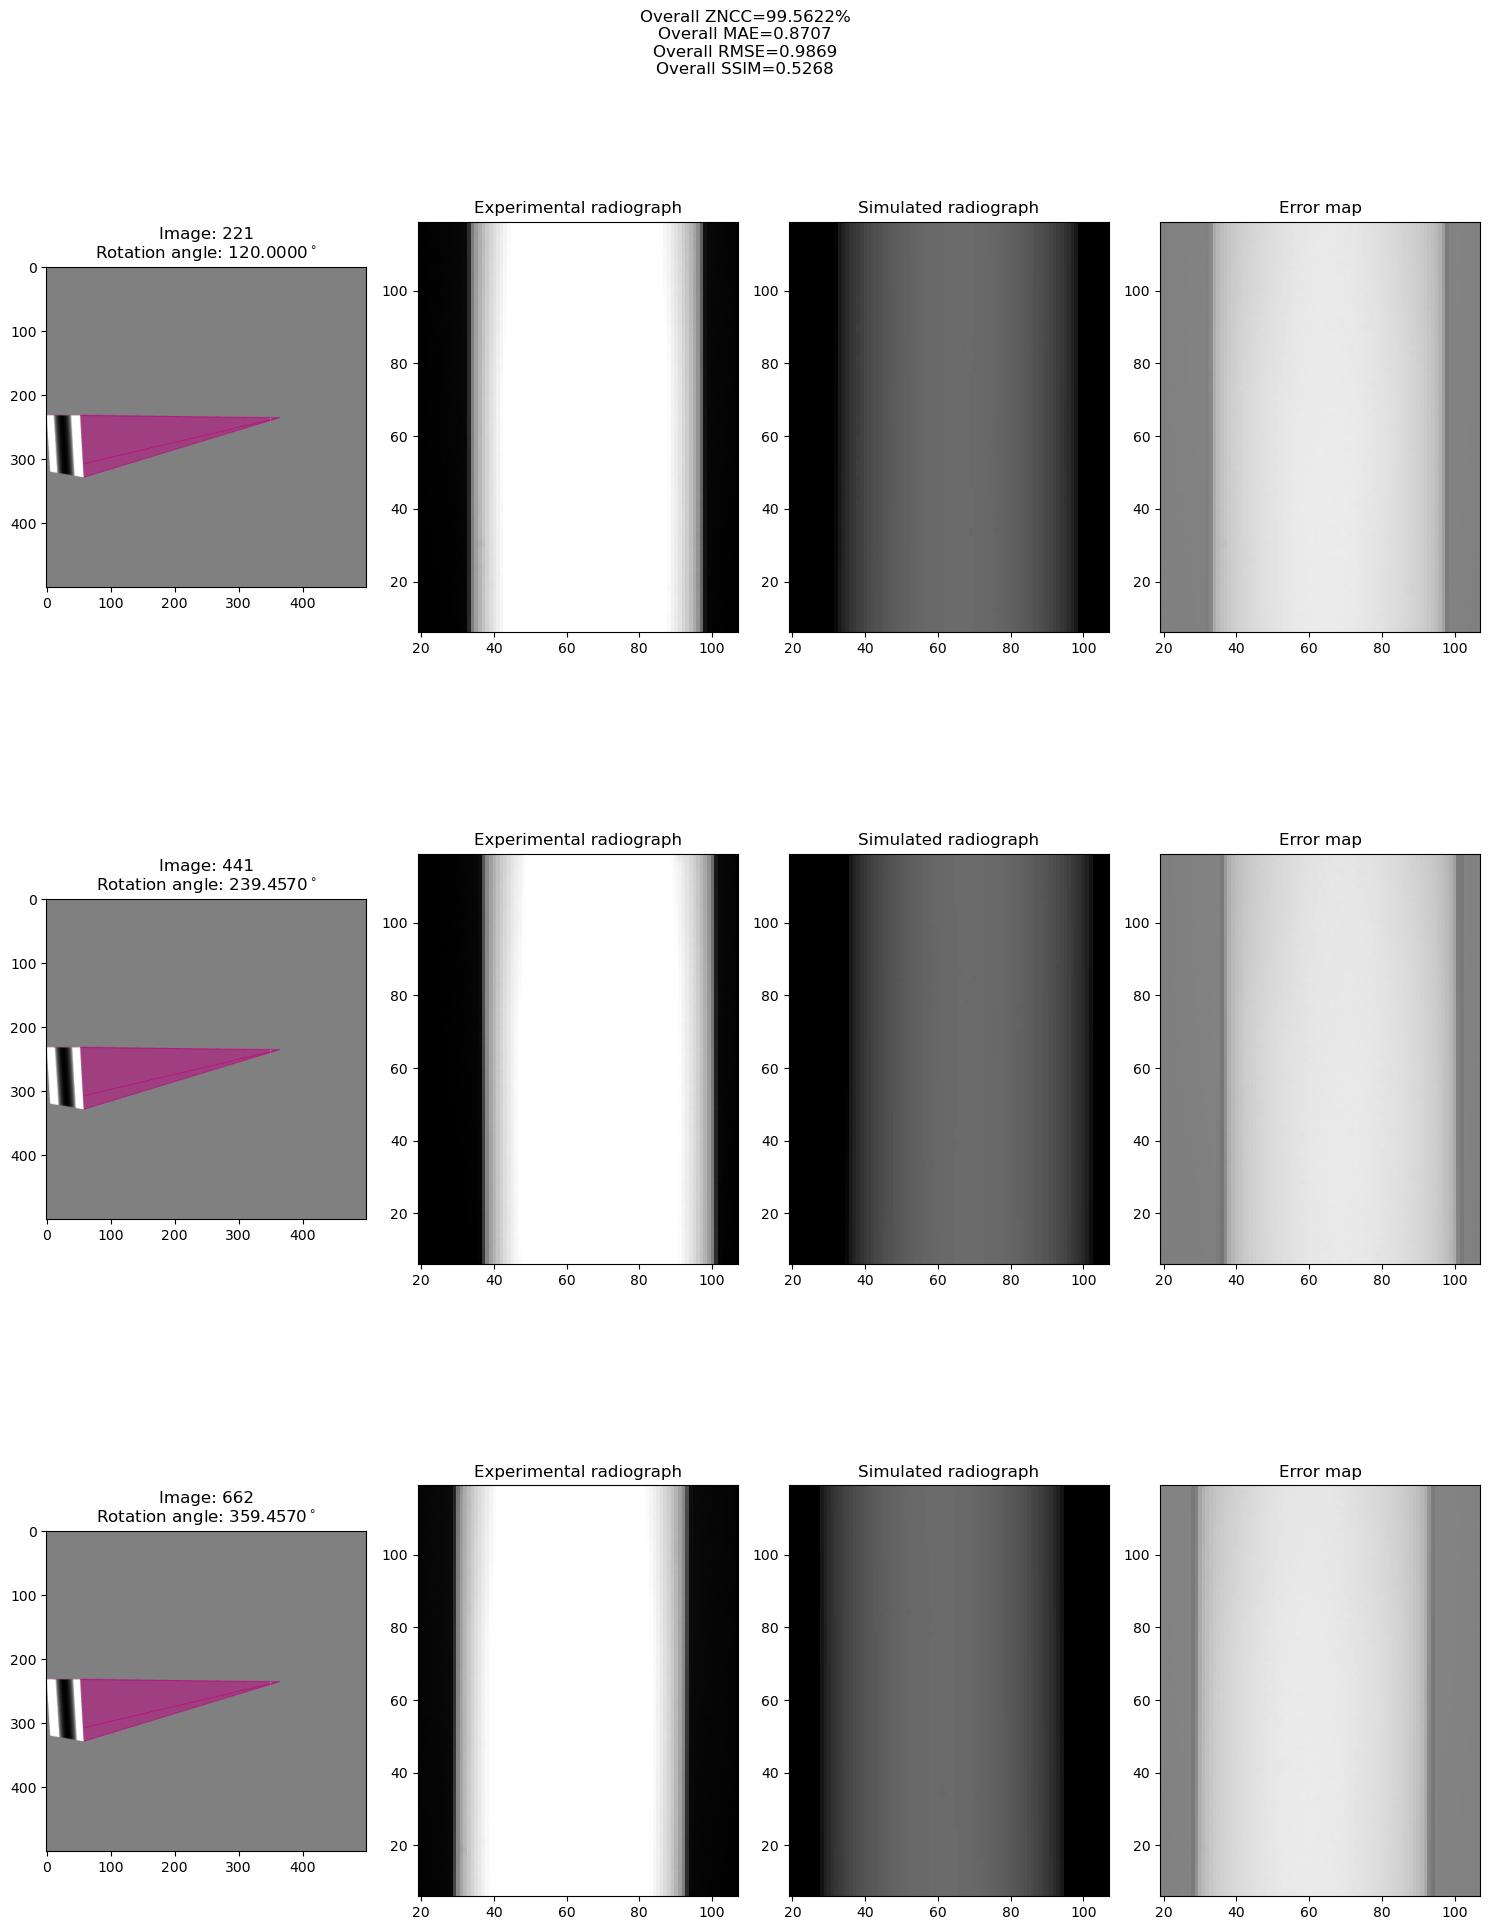

In [17]:
displayResult(utils.x_current, figsize=utils.figsize, fname=None, crop=True)

In [18]:
downscale = 4
utils.figsize=(15,21)
gvxr.setDetectorNumberOfPixels(round(DetectorPixelsX / downscale), round(DetectorPixelsY / downscale));
gvxr.setDetectorPixelSize(DetectorPixelSizeX * downscale, DetectorPixelSizeY * downscale, "mm");
utils.ref_image, utils.selected_angles, utils.indices = getReference(experimental_img_paths, 
                                                                     angles, 
                                                                     5, 
                                                                     WhiteLevel,
                                                                     downscale)

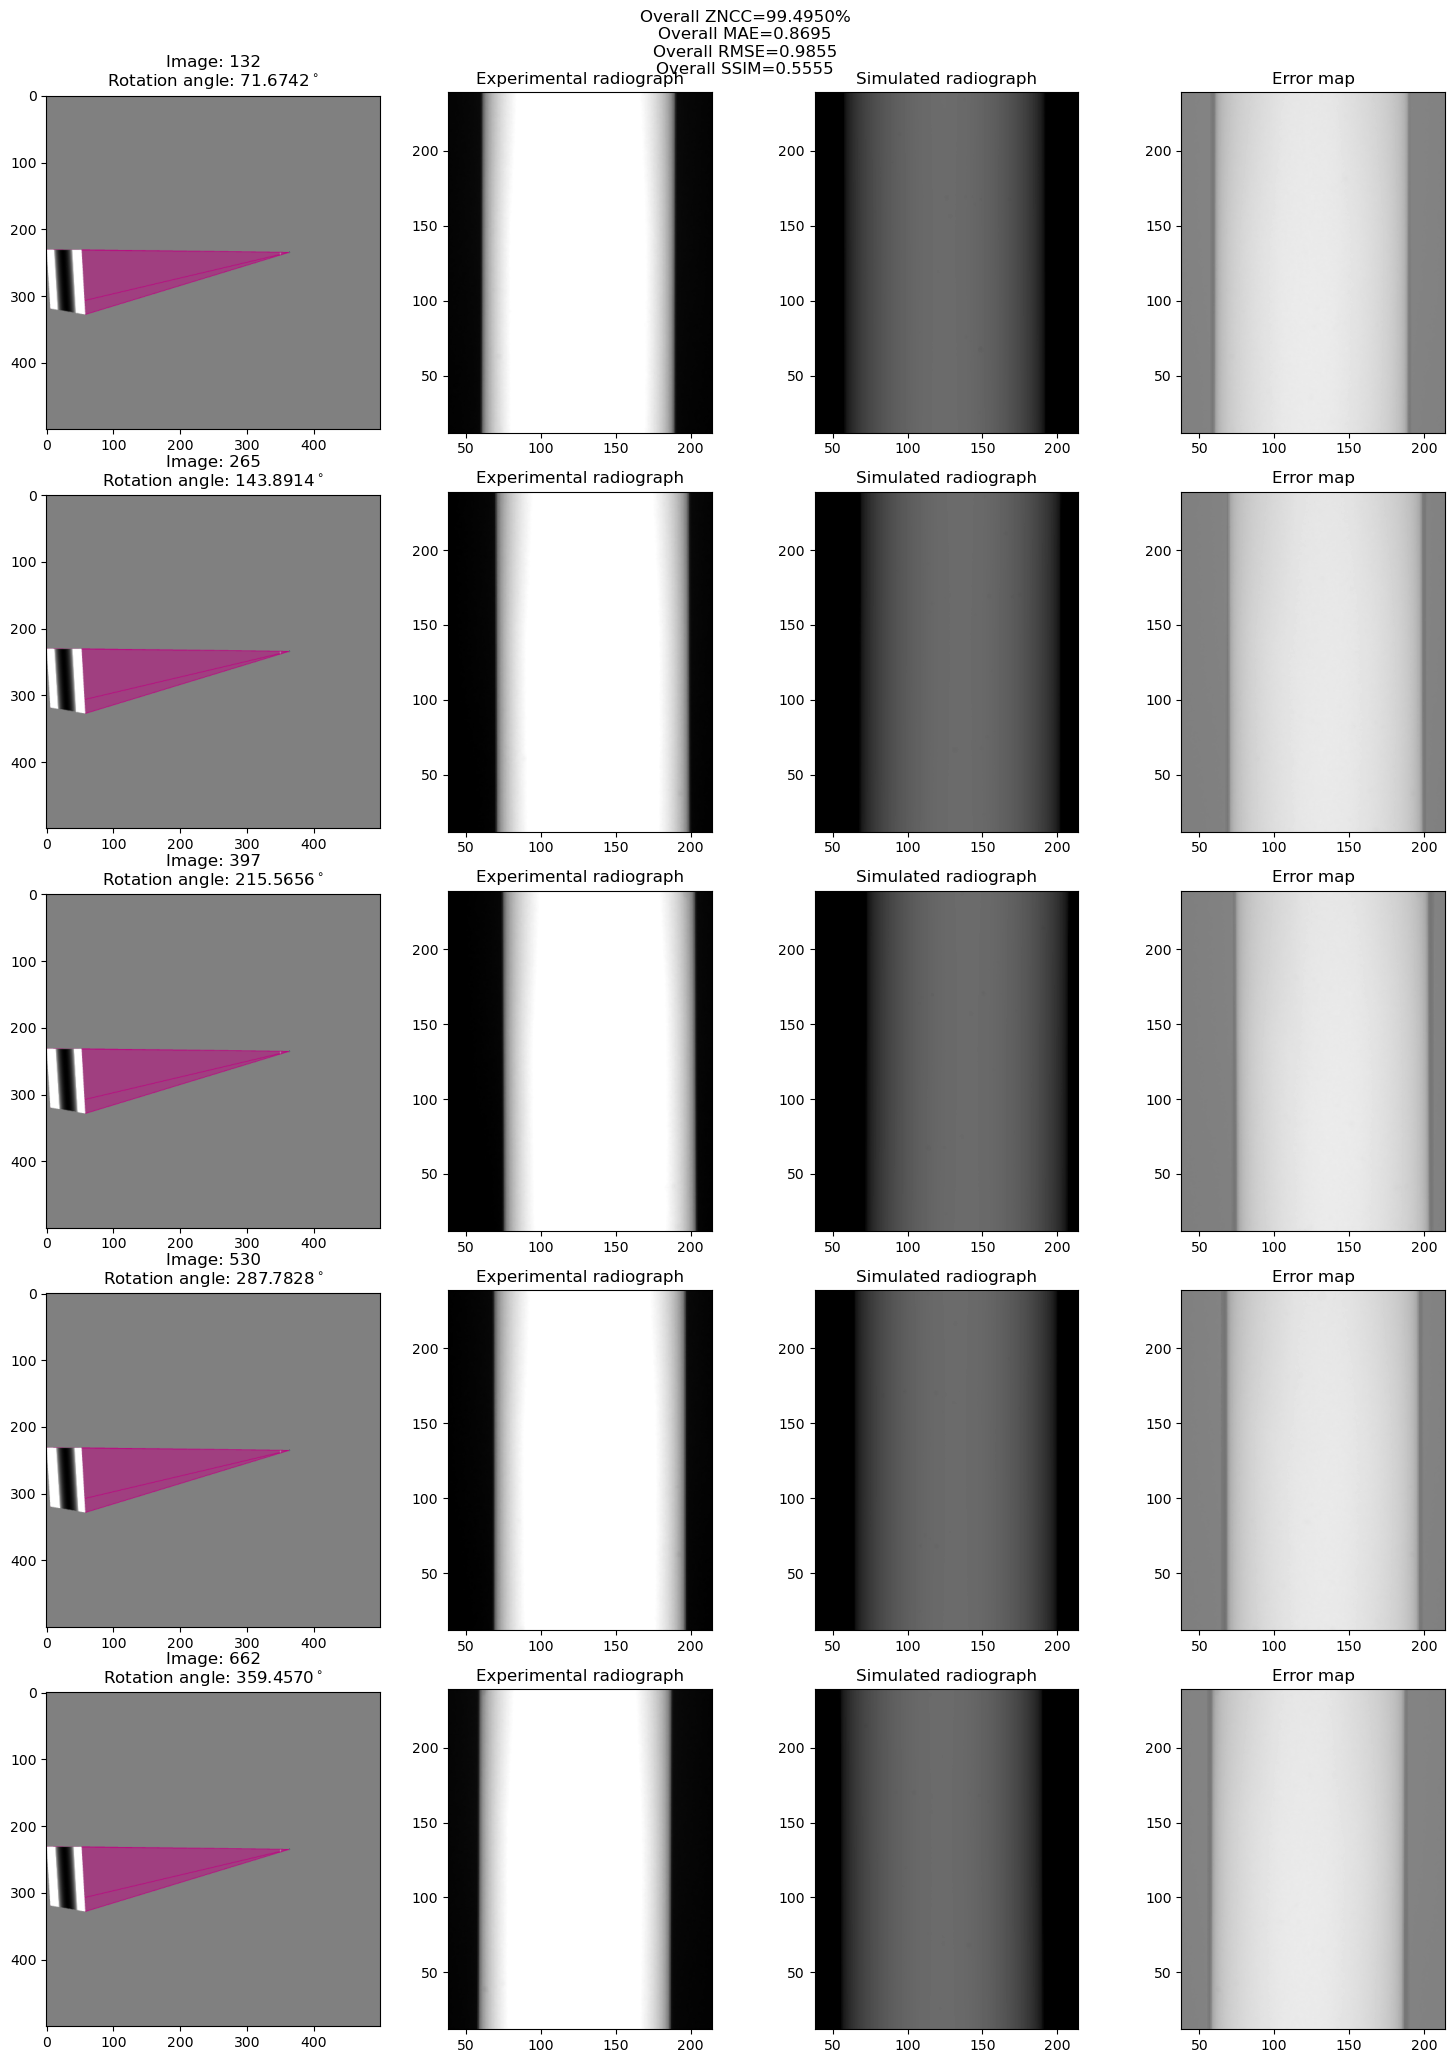

In [19]:
displayResult(utils.x_current, figsize=utils.figsize, fname=None, crop=True)

In [20]:
opts = cma.CMAOptions()
opts.set('tolfun', 1e-5);
opts['tolx'] = 1e-5;
opts['bounds'] = [
    utils.x_current - 2,
    utils.x_current + 2
]

x_fname       = os.path.join(registration_dir, "x_best2.dat")
fitness_fname = os.path.join(registration_dir, "fitness_set2.npz")
utils.plot_directory = os.path.join(registration_dir, "plot2")

if not os.path.exists(x_fname) or not os.path.exists(fitness_fname):
    
    if os.path.isdir(utils.plot_directory):
        shutil.rmtree(utils.plot_directory)

    if not os.path.exists(utils.plot_directory):
        os.mkdir(utils.plot_directory)    

    utils.best_fitness = sys.float_info.max
    utils.fitness_set = []
    utils.counter = 1

    start_time = time.time();
    es = cma.CMAEvolutionStrategy(utils.x_current, 2 / 10, opts);
    es.optimize(fitnessZNCC);
    elapsed_time = time.time() - start_time

    x_best2 = es.result.xbest
    np.savetxt(x_fname, es.result.xbest)

    utils.fitness_set = np.array(utils.fitness_set)
    np.savez(fitness_fname, utils.fitness_set)

    
else:
    x_best2 = np.loadtxt(x_fname)
    data = np.load(fitness_fname)
    lst = data.files
    utils.fitness_set = data[lst[0]]

utils.x_current = x_best2

(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=975250, Tue May 28 06:27:30 2024)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      9 1.020510704176211e+00 1.0e+00 1.73e-01  2e-01  2e-01 0:24.2
    2     18 1.013228774938916e+00 1.2e+00 1.76e-01  2e-01  2e-01 0:30.6
    3     27 1.020086299588563e+00 1.4e+00 1.66e-01  1e-01  2e-01 0:32.5
    4     36 1.011937310874069e+00 1.5e+00 1.56e-01  1e-01  2e-01 0:39.1
    6     54 1.018163314946056e+00 2.0e+00 1.36e-01  1e-01  2e-01 0:43.5
    7     63 1.008357755092623e+00 2.1e+00 1.27e-01  1e-01  1e-01 0:49.9
    8     72 1.008258574500026e+00 2.0e+00 1.26e-01  1e-01  1e-01 0:56.1
    9     81 1.005592339413534e+00 2.0e+00 1.15e-01  9e-02  1e-01 1:06.8
   11     99 1.004633472623792e+00 2.2e+00 8.75e-02  6e-02  1e-01 1:19.7
   14    126 1.004680011941665e+00 2.6e+00 5.48e-02  3e-02  6e-02 1:30.2
   20    180 1.004044325683479e+00 3.7e+00 3.20e-02  1e-02  4e-02 1:46.2
   24    216 1.004053846550927e+00 

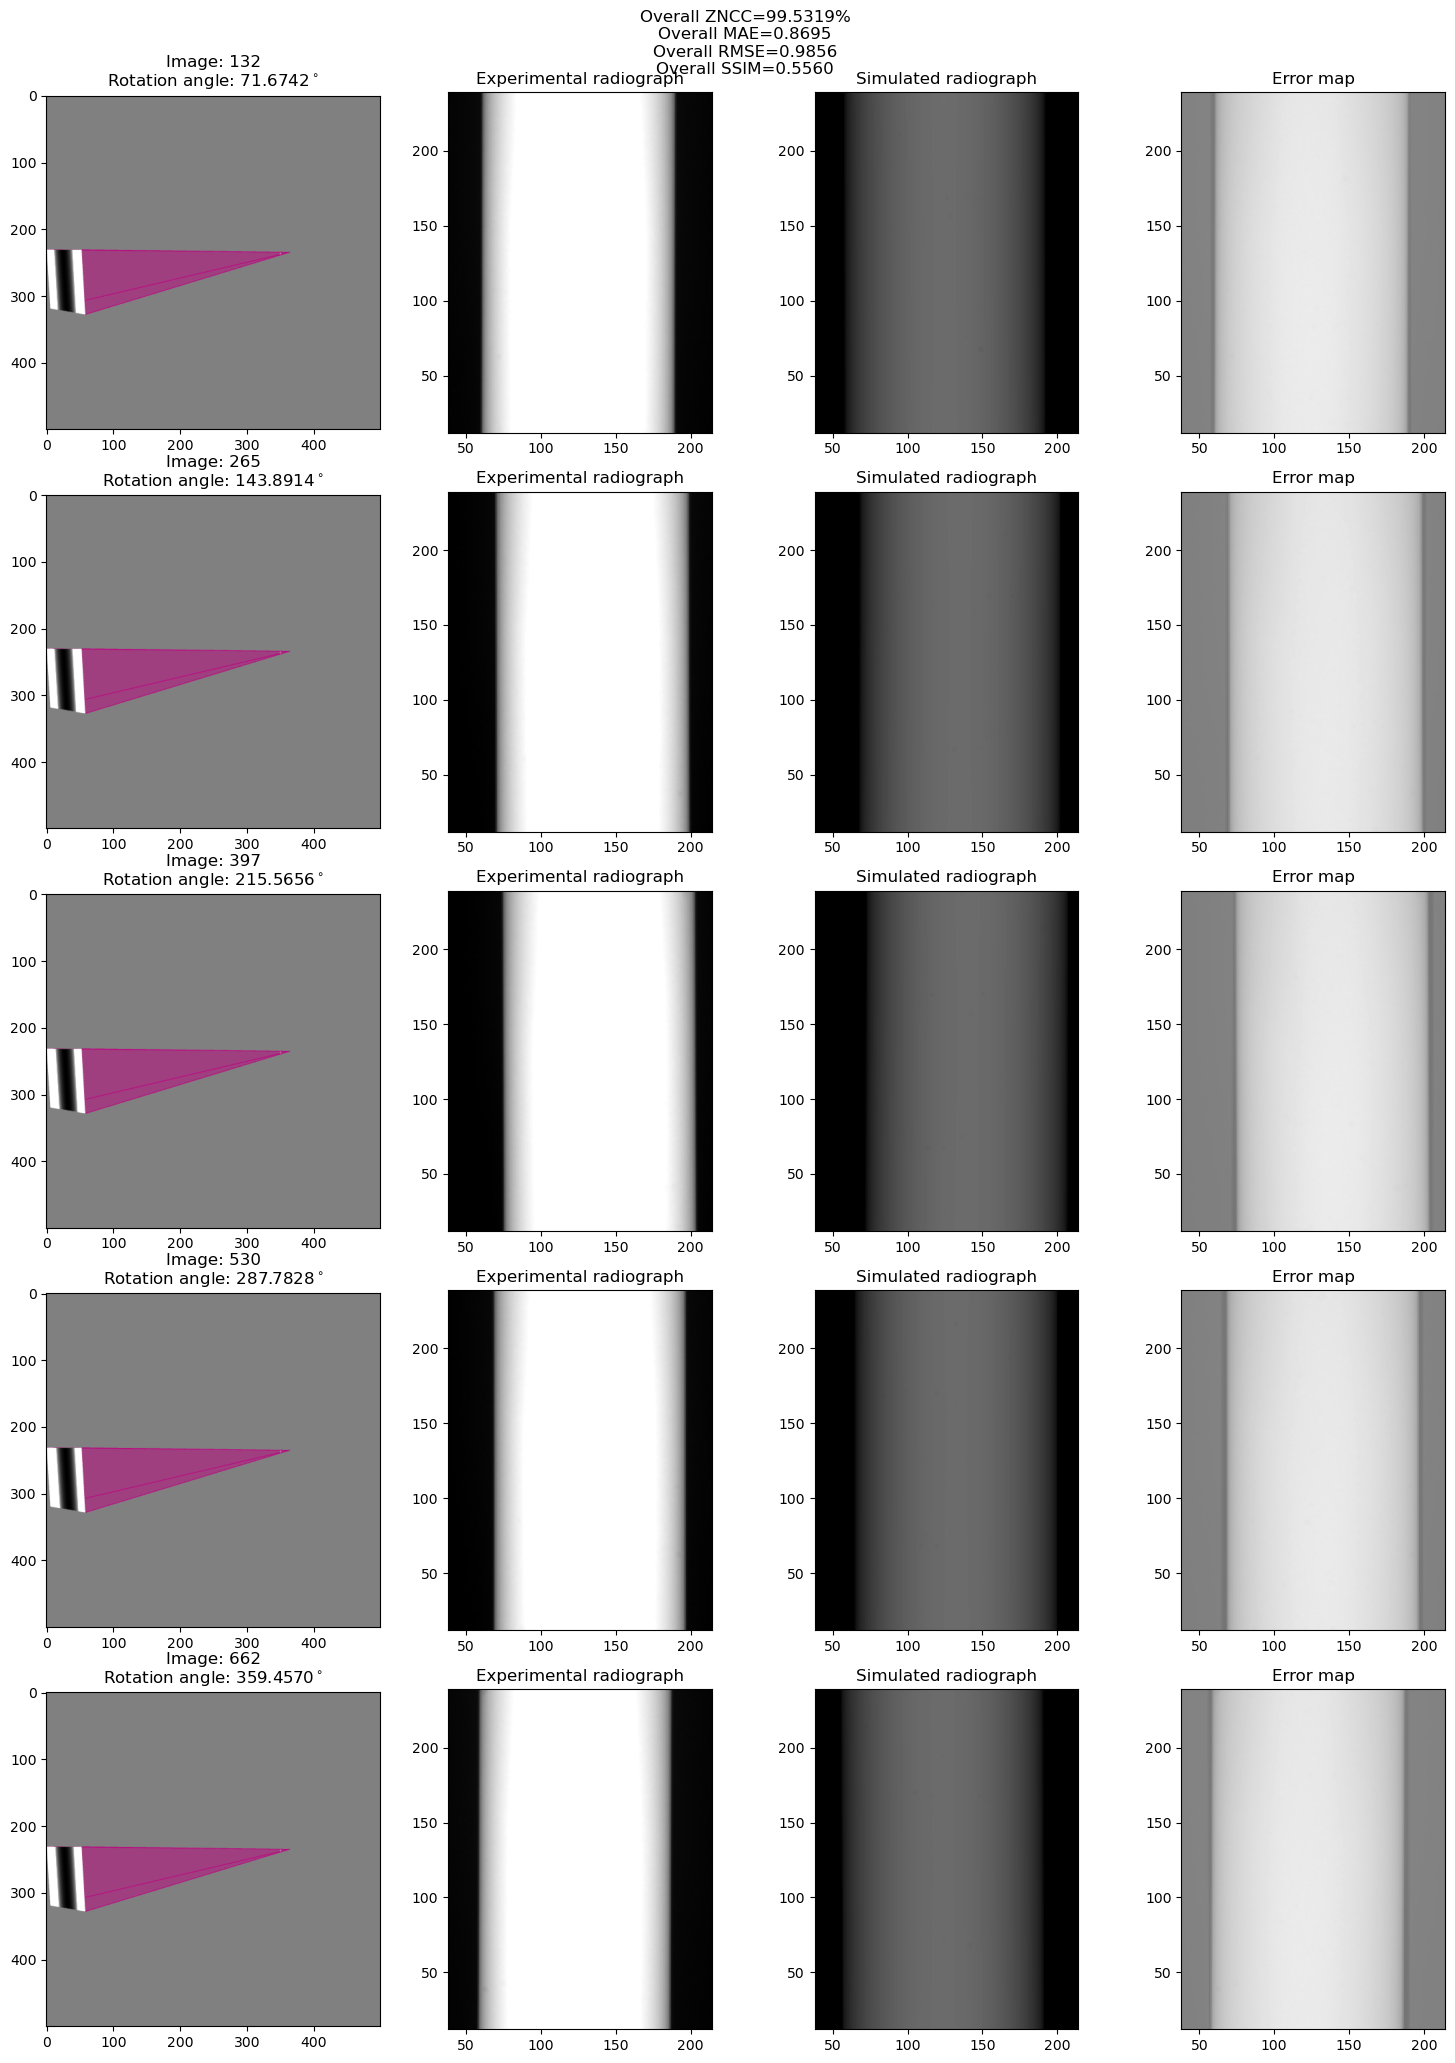

In [21]:
displayResult(utils.x_current, figsize=utils.figsize, fname=None, crop=True)

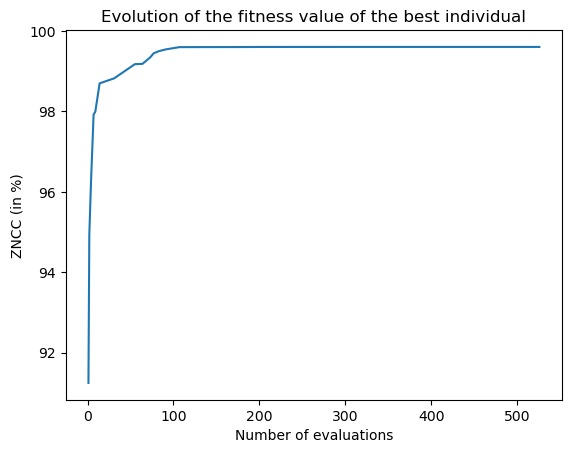

In [22]:
plt.figure()
plt.title("Evolution of the fitness value of the best individual")
plt.ylabel("ZNCC (in %)")
plt.xlabel("Number of evaluations")
plt.plot(utils.fitness_set[:, 0], 100.0 / utils.fitness_set[:, 1])
plt.show()

In [23]:
downscale = 1
utils.figsize=(15,21)
gvxr.setDetectorNumberOfPixels(round(DetectorPixelsX / downscale), round(DetectorPixelsY / downscale));
gvxr.setDetectorPixelSize(DetectorPixelSizeX * downscale, DetectorPixelSizeY * downscale, "mm");
utils.ref_image, utils.selected_angles, utils.indices = getReference(experimental_img_paths, 
                                                                     angles, 
                                                                     7, 
                                                                     WhiteLevel,
                                                                     downscale)

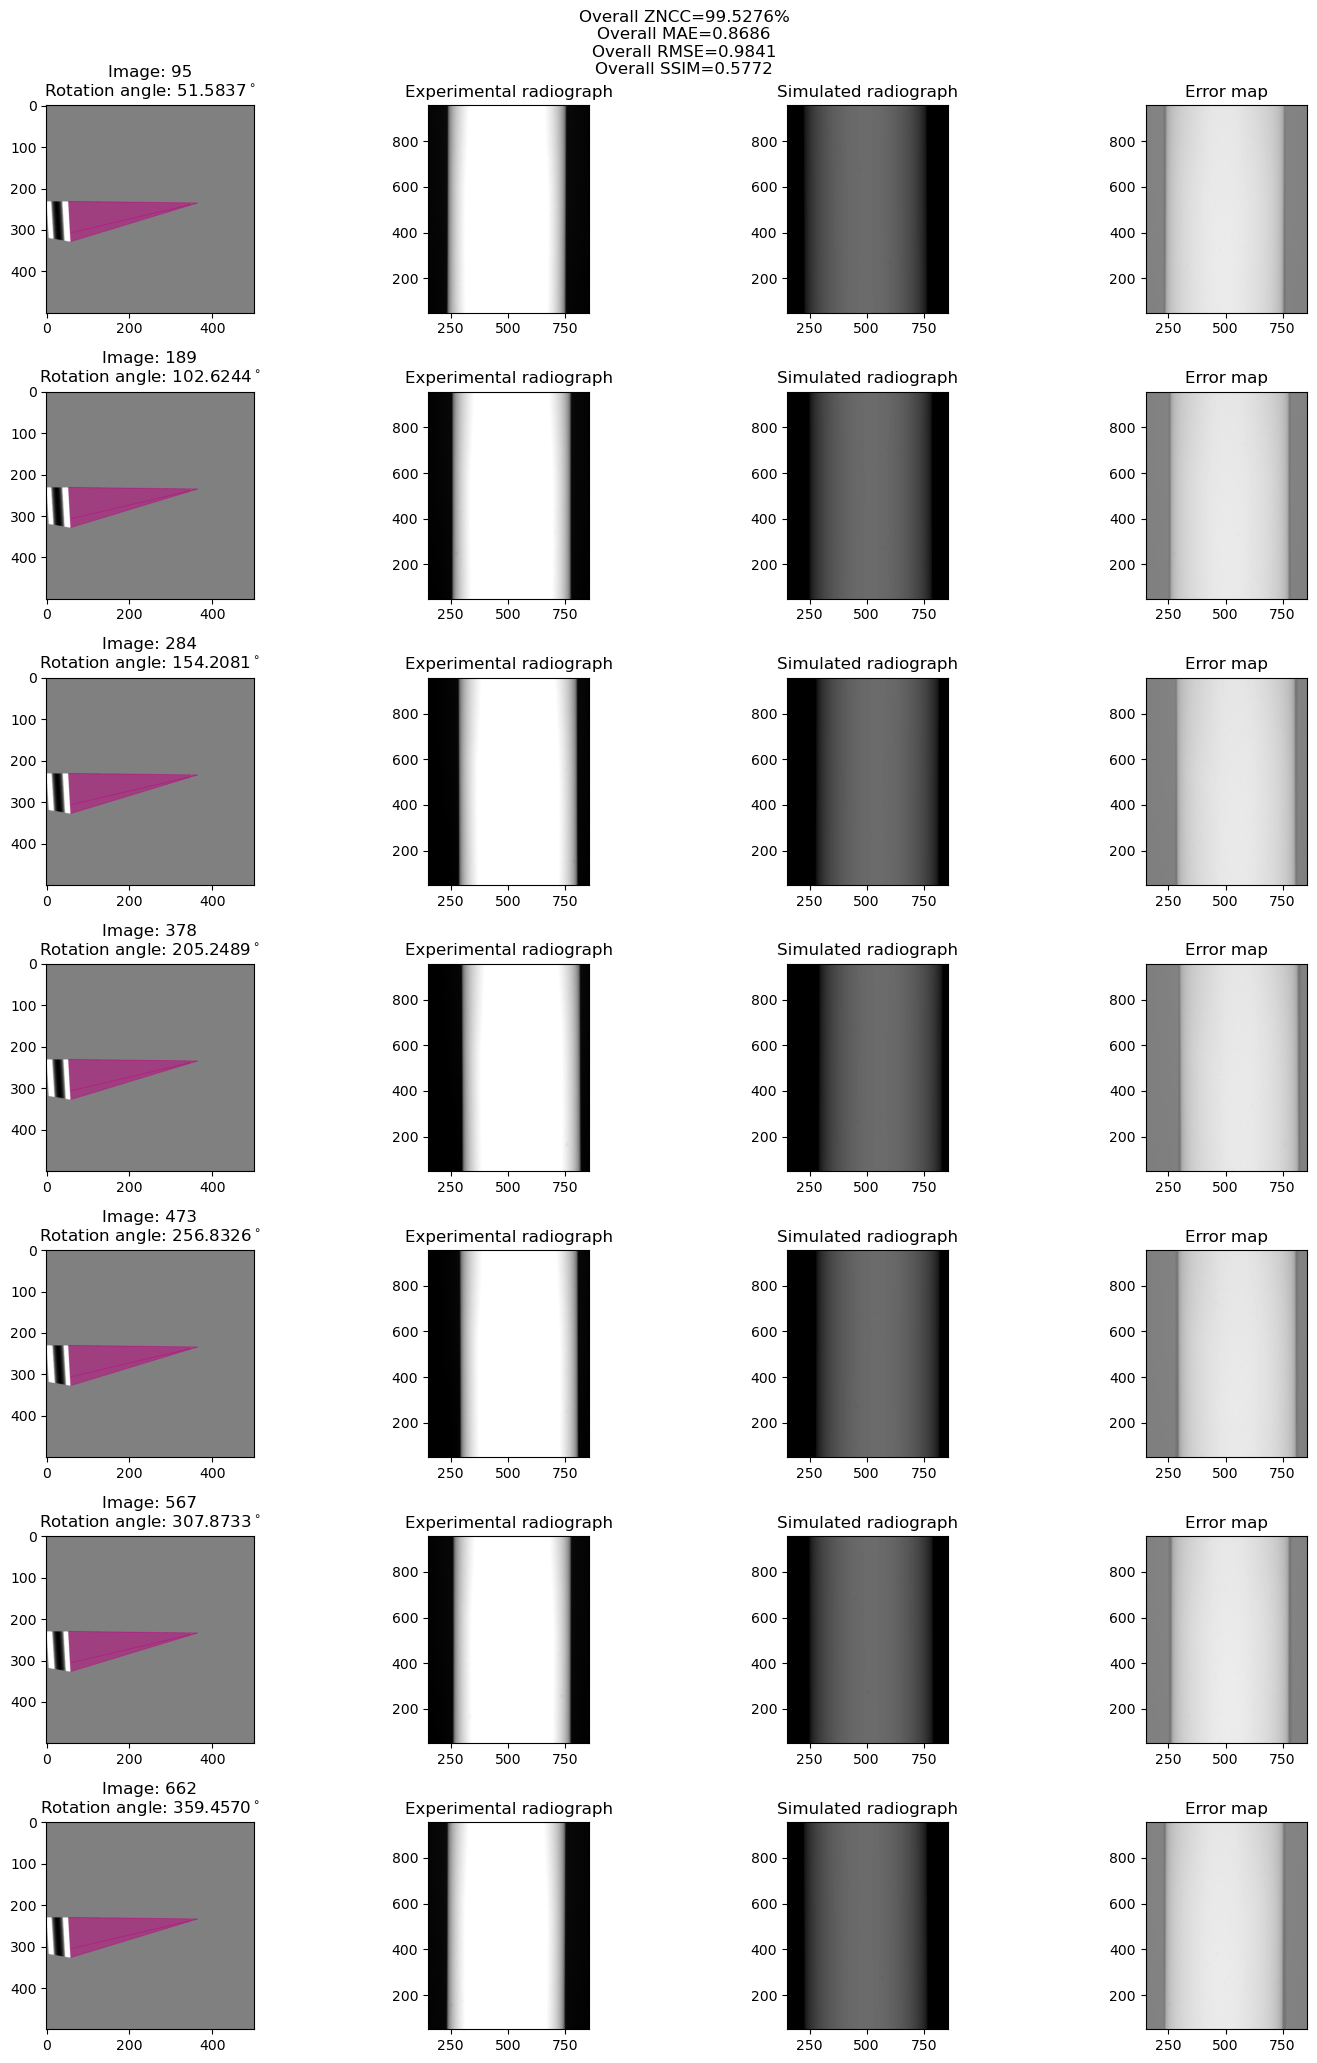

In [24]:
displayResult(utils.x_current, figsize=utils.figsize, fname=None, crop=True)

In [25]:
opts = cma.CMAOptions()
opts.set('tolfun', 1e-5);
opts['tolx'] = 1e-5;
opts['bounds'] = [
    utils.x_current - 2,
    utils.x_current + 2
]

x_fname       = os.path.join(registration_dir, "x_best3.dat")
fitness_fname = os.path.join(registration_dir, "fitness_set3.npz")
utils.plot_directory = os.path.join(registration_dir, "plot3")

if not os.path.exists(x_fname) or not os.path.exists(fitness_fname):
    
    if os.path.isdir(utils.plot_directory):
        shutil.rmtree(utils.plot_directory)

    if not os.path.exists(utils.plot_directory):
        os.mkdir(utils.plot_directory)    

    utils.best_fitness = sys.float_info.max
    utils.fitness_set = []
    utils.counter = 1

    start_time = time.time();
    es = cma.CMAEvolutionStrategy(utils.x_current, 2 / 10, opts);
    es.optimize(fitnessZNCC);
    elapsed_time = time.time() - start_time

    x_best3 = es.result.xbest
    np.savetxt(x_fname, es.result.xbest)

    utils.fitness_set = np.array(utils.fitness_set)
    np.savez(fitness_fname, utils.fitness_set)

    
else:
    x_best3 = np.loadtxt(x_fname)
    data = np.load(fitness_fname)
    lst = data.files
    utils.fitness_set = data[lst[0]]

utils.x_current = x_best3

(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=944047, Tue May 28 06:32:08 2024)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      9 1.010107316333791e+00 1.0e+00 1.90e-01  2e-01  2e-01 0:30.8
    2     18 1.011977036043398e+00 1.3e+00 1.78e-01  2e-01  2e-01 0:42.2
    3     27 1.008663744941177e+00 1.4e+00 1.59e-01  1e-01  2e-01 1:01.9
    4     36 1.013365974866568e+00 1.5e+00 1.35e-01  1e-01  1e-01 1:13.4
    5     45 1.014640351558114e+00 1.6e+00 1.29e-01  1e-01  1e-01 1:23.8
    6     54 1.007092016943971e+00 2.1e+00 1.19e-01  8e-02  1e-01 1:44.7
    7     63 1.008265036959738e+00 2.4e+00 1.09e-01  7e-02  1e-01 1:55.5
    8     72 1.006260013716537e+00 2.6e+00 9.89e-02  6e-02  1e-01 2:15.8
    9     81 1.004499887835596e+00 2.7e+00 9.36e-02  6e-02  1e-01 2:36.2
   10     90 1.005788036008091e+00 2.8e+00 8.80e-02  5e-02  1e-01 2:47.4
   11     99 1.004776765410096e+00 2.8e+00 8.17e-02  4e-02  9e-02 2:59.3
   12    108 1.005038175613839e+00 

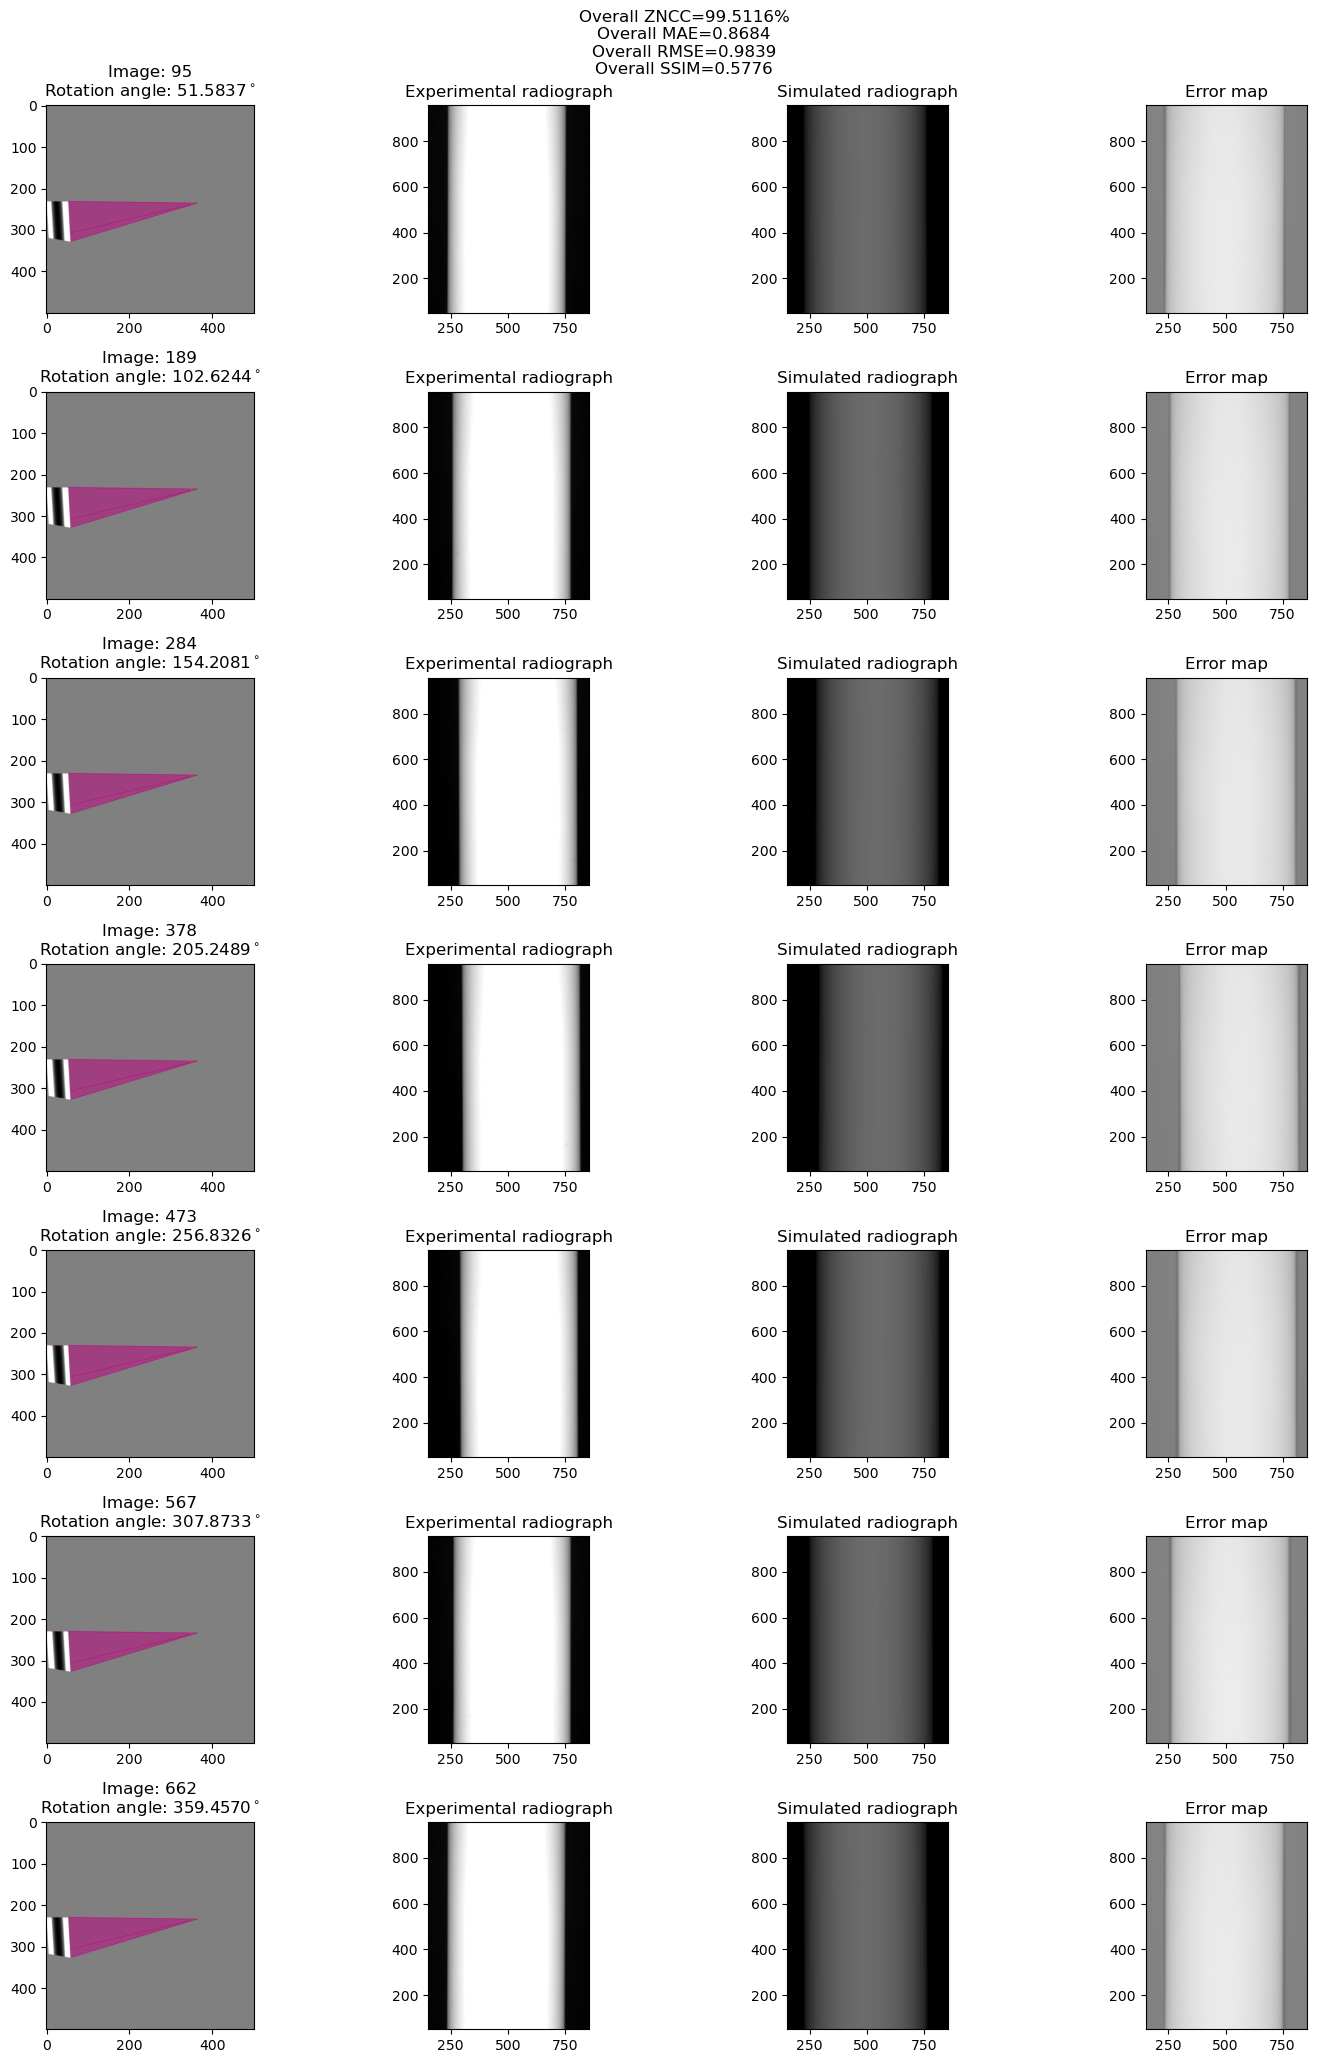

In [26]:
displayResult(utils.x_current, figsize=utils.figsize, fname=None, crop=True)

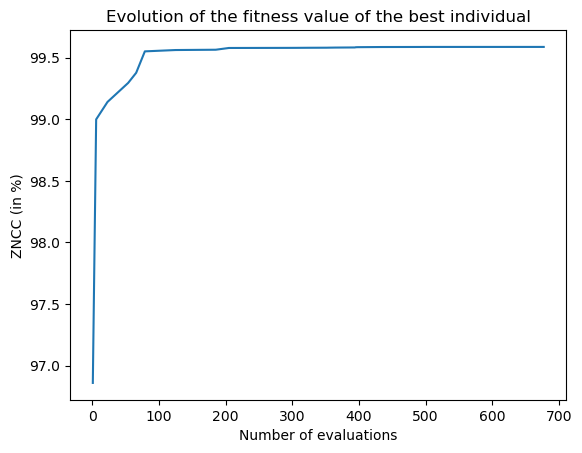

In [27]:
plt.figure()
plt.title("Evolution of the fitness value of the best individual")
plt.ylabel("ZNCC (in %)")
plt.xlabel("Number of evaluations")
plt.plot(utils.fitness_set[:, 0], 100.0 / utils.fitness_set[:, 1])
plt.show()

In [28]:
gvxr.setScintillator("Gd2O2S DRZ-Plus", 210, "um")
# Gadox (Gd2O2S) DRZ+ : scintillator of 100mg/cm2 and 210um thickness which gives an apparent density of 4.76 g/cm3

RuntimeError: Error: This material (Gd2O2S DRZ-Plus) is not supported. Contact Franck Vidal if you think it should be added.
	- in File: C:\Users\franc\OneDrive\Documents\PROGRAMMING\gvirtualxray-trunk\gvxr\include\gVirtualXRay\Scintillator.inl
	- in Function: gVirtualXRay::Scintillator::setMaterial
	- at Line: 155


In [ ]:
if has_spekpy:
    loadSpectrumSpekpy(XraykV, filters=None, th_in_deg=12)
elif has_xpecgen:
    loadSpectrumXpecgen(XraykV, filters=None, th_in_deg=12)

In [ ]:
energy_bins = np.array(gvxr.getEnergyBins("keV"))
photon_counts = np.array(gvxr.getPhotonCountEnergyBins())

plotSpectrum(energy_bins,
             photon_counts,
             fname=None,
             xlim=[0,200],
             figsize=(20,10))

In [ ]:
displayResult(utils.x_current, figsize=utils.figsize, fname=None, crop=True)

In [ ]:
gvxr.removePolygonMeshesFromSceneGraph()

mesh_fname = os.path.join(mesh_dir, "steel-smoothed" + ".stl")
gvxr.loadMeshFile("steel-smoothed", mesh_fname, "mm")

gvxr.setMixture("steel-smoothed", utils.elements, utils.default_weights)
gvxr.setDensity("steel-smoothed", utils.default_density, "g/cm3")

bbox_in_mm = gvxr.getNodeAndChildrenBoundingBox("steel-smoothed", "mm")

gvxr.translateNode("steel-smoothed",
                    -bbox_in_mm[0] - (bbox_in_mm[3] - bbox_in_mm[0]) / 2.0,
                    -bbox_in_mm[1] - (bbox_in_mm[4] - bbox_in_mm[1]) / 2.0,
                    -bbox_in_mm[2] - (bbox_in_mm[5] - bbox_in_mm[2]) / 2.0,
                    "mm"
                    )

gvxr.applyCurrentLocalTransformation("steel-smoothed")

# Sample position on turntable
gvxr.translateNode("steel-smoothed", utils.x_current[0], utils.x_current[1], utils.x_current[2], "mm")

# gvxr.rotateNode(utils.sample_label, utils.x_current[6], 1, 0, 0)
# gvxr.rotateNode(utils.sample_label, utils.x_current[7], 0, 1, 0)

gvxr.applyCurrentLocalTransformation("steel-smoothed")

mesh_fname = os.path.join(mesh_dir, "steel-smoothed" + "-transformed.stl")
gvxr.saveSTLfile("steel-smoothed", mesh_fname);

In [ ]:
JSON_fname = os.path.join(base_dir, "CT-acquisition-real_part.json")
proj_path = os.path.join(base_dir, "simulated_projections-real_part")

simulated_projections = False
if not os.path.exists(JSON_fname) or not os.path.exists(proj_path):
    gvxr.computeCTAcquisition(proj_path,
                              "",
                              N_slices,
                              angles[0],
                              True,
                              angles[-1],
                              50,
                              -utils.x_current[3], -utils.x_current[4], -utils.x_current[5],
                              "mm",
                              0, 0, 1);
    
    simulated_projections = True;

In [ ]:
if simulated_projections:
    gvxr2json.saveJSON(JSON_fname)

In [ ]:
gvxr.terminate()

In [ ]:
# Import packages
from cil.processors import TransmissionAbsorptionConverter, Slicer
from cil.recon import FDK

from cil.utilities.display import show2D, show_geometry
from cil.utilities.jupyter import islicer

from gvxrPython3.JSON2gVXRDataReader import JSON2gVXRDataReader

In [ ]:
detector_response = np.array(gvxr.getEnergyResponse("keV"))
plt.figure(figsize= (20,10))
# plt.title("Detector response")
plt.plot(detector_response[:,0], detector_response[:,1])
plt.xlabel('Incident energy: E (in keV)')
plt.ylabel('Detector energy response: $\\delta$(E) (in keV)')

plt.tight_layout()

In [ ]:
opts = cma.CMAOptions()
opts.set('tolfun', 1e-5);
opts['tolx'] = 1e-5;
opts['bounds'] = [(len(utils.default_weights)+1)*[0.001], (len(utils.default_weights)+1)*[2]];

x_fname       = os.path.join(registration_dir, "x_best3.dat")
fitness_fname = os.path.join(registration_dir, "fitness_set3.npz")
utils.plot_directory = os.path.join(registration_dir, "plot3")

if not os.path.exists(x_fname) or not os.path.exists(fitness_fname):
    
    if os.path.isdir(utils.plot_directory):
        shutil.rmtree(utils.plot_directory)

    if not os.path.exists(utils.plot_directory):
        os.mkdir(utils.plot_directory)    

    utils.best_fitness = sys.float_info.max
    utils.fitness_set = []
    utils.counter = 1

    start_time = time.time();
    es = cma.CMAEvolutionStrategy((len(utils.default_weights)+1)*[1], 0.5, opts);
    es.optimize(fitnessZNCC);
    elapsed_time = time.time() - start_time

    x_best3 = es.result.xbest
    np.savetxt(x_fname, es.result.xbest)

    utils.fitness_set = np.array(utils.fitness_set)
    np.savez(fitness_fname, utils.fitness_set)

    
else:
    x_best3 = np.loadtxt(x_fname)
    data = np.load(fitness_fname)
    lst = data.files
    utils.fitness_set = data[lst[0]]

    
temp_weight = []
for i in range(len(utils.default_weights)):
    temp_weight.append(x_best3[i+1] * utils.default_weights[i])

temp_weight = np.array(temp_weight) / np.sum(temp_weight)
gvxr.setMixture("steel-smoothed",
                utils.elements,
                temp_weight)

sample_density = x_best3[0] * default_density
gvxr.setDensity("steel-smoothed", sample_density, "g/cm3")

gvxr2json.saveJSON("test.json")

In [ ]:
print("Default density:", default_density, "g/cm3")
print("Optimised density:", sample_density, "g/cm3")


print(np.sum(temp_weight))
for i in range(len(utils.default_weights)):
    print("\t", utils.elements[i], str(100 * utils.default_weights[i])+"%", str(100 * temp_weight[i])+"%")

In [ ]:
plt.figure()
plt.title("Evolution of the fitness value of the best individual")
plt.ylabel("ZNCC (in %)")
plt.xlabel("Number of evaluations")
plt.plot(utils.fitness_set[:, 0], 100.0 / utils.fitness_set[:, 1])
plt.show()

In [ ]:
displayResult(x_best3, figsize=utils.figsize, fname=None, crop=True)

In [ ]:
downscale = 1
gvxr.setDetectorNumberOfPixels(round(DetectorPixelsX / downscale), round(DetectorPixelsY / downscale));
gvxr.setDetectorPixelSize(DetectorPixelSizeX * downscale, DetectorPixelSizeY * downscale, "mm");

utils.ref_image, utils.selected_angles, utils.indices = getReference(experimental_img_paths, 
                                                                     angles, 
                                                                     5, 
                                                                     WhiteLevel,
                                                                     downscale)

In [ ]:
displayResult(x_best3, figsize=utils.figsize, fname=os.path.join(registration_dir, "registration_results"), crop=True)

In [ ]:
test_default_densities = getXrayImage((len(utils.default_weights)+1)*[1])
test_optimised_densities = getXrayImage(x_best3)

fig, axs = plt.subplots(len(utils.ref_image), 1, figsize=(12,20), squeeze=False)
plt.suptitle("Intensity profiles through the middle row")

row_id = test_optimised_densities.shape[1] // 2
row_size = test_optimised_densities.shape[2]

for index in range(len(utils.ref_image)):
    axs[index][0].plot(utils.ref_image[index][row_id], label="Experimental")
    axs[index][0].plot(test_default_densities[index][row_id], label="Default densities")
    axs[index][0].plot(test_optimised_densities[index][row_id], label="Optimised densities")
    axs[index][0].set_xlim((500, row_size-500))
    axs[index][0].set_xlabel("Pixel position")
    axs[index][0].set_ylabel("Pixel intensity")
    axs[index][0].legend()

In [ ]:
gvxr2json.saveJSON("test.json")

In [ ]:
gvxr.terminate()